# Bi-color analysis

This notebook performs analysis of data quantified through `BC_clusterkinetics_pipeline.py`. It aims at analysing data with N samples condition (*eg. unt, cb 4h, cb8h, cb16h, ...*)

In [71]:
FIGSIZE = (15,15)
BINS = 100

EXPECTED_TREATMENT_NUMBER = 6
SIGNIFICANCE = 0.01

SINGLE_MOLECULES_KEYS = []
OTHER_KEYS = ["cell_line","treatment"]

PATH_IN= "/media/floricslimani/SSD4To/SSD_floricslimani/Fish_seq/Manon/time_course_CB/pipeline_output/240429_time_course_CB_20241106_13-52-27/result_tables/"

Z_SCORE = 2.575829 # 99% confidence interval

## Open data & prepare folder

In [72]:
import pandas as pd

Acquisition = pd.read_feather(PATH_IN + '/Acquisition.feather')
Cell = pd.read_feather(PATH_IN + '/Cell.feather')
Spots = pd.read_feather(PATH_IN + '/Spots.feather')
Spots['spots_id'] = range(len(Spots))
Acquisition

,acquisition_id,filename,date,rna1,cell_line,treatment,fov,rna2,Runtime_date,colocalisation_distance,rna1_threshold,rna2_threshold,suntag_threshold,rna1_deconvolution_sucess,rna2_deconvolution_sucess,suntag_deconvolution_sucess
0,0,240429_POLR2B_hct_cb-16h-02.czi,240429,POLR2B,hct,cb-16h,02,NaN,20241106 13-52-27,310.0,400.0,NaN,NaN,True,False,False
1,1,240429_POLR2B_kyoto_cb-4h-03.czi,240429,POLR2B,kyoto,cb-4h,03,NaN,20241106 13-52-27,310.0,330.0,NaN,NaN,True,False,False
2,2,240429_POLR2B_hek_cb-16h-04.czi,240429,POLR2B,hek,cb-16h,04,NaN,20241106 13-52-27,310.0,430.0,NaN,NaN,True,False,False
3,3,240429_POLR2B_kyoto_cb-16h-02.czi,240429,POLR2B,kyoto,cb-16h,02,NaN,20241106 13-52-27,310.0,330.0,NaN,NaN,True,False,False
4,4,240429_POLR2B_hct_cb-puro-04.czi,240429,POLR2B,hct,cb-puro,04,NaN,20241106 13-52-27,310.0,400.0,NaN,NaN,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,57,240429_POLR2B_kyoto_cb-4h-01.czi,240429,POLR2B,kyoto,cb-4h,01,NaN,20241106 13-52-27,310.0,330.0,NaN,NaN,True,False,False
58,58,240429_POLR2B_hct_unt-03.czi,240429,POLR2B,hct,unt,03,NaN,20241106 13-52-27,310.0,400.0,NaN,NaN,True,False,False
59,59,240429_POLR2B_hek_cb-puro-01.czi,240429,POLR2B,hek,cb-puro,01,NaN,20241106 13-52-27,310.0,430.0,NaN,NaN,True,False,False
60,60,240429_POLR2B_hek_cb-puro-04.czi,240429,POLR2B,hek,cb-puro,04,NaN,20241106 13-52-27,310.0,430.0,NaN,NaN,True,False,False


In [96]:
clustered_spots = Spots.groupby('cell_id')['is_clustered'].sum()
total_spots = Spots.groupby('cell_id')['spots_id'].count()
clustered_spots

cell_id
8.0        89
9.0       188
10.0      110
11.0      213
13.0      126
         ... 
3809.0    253
3810.0    246
3811.0    290
3812.0    194
3813.0    302
Name: is_clustered, Length: 3185, dtype: int64

In [73]:
for table in [Acquisition, Cell] :
    if type(table['acquisition_id'].iat[0]) == list:
        table['acquisition_id'] = table['acquisition_id'].apply(tuple)

acq_columns = ['acquisition_id']

for col in ['rna1', 'rna2', 'suntag', 'treatment', 'cell_line'] :
    if col in Acquisition.columns :
        acq_columns.append(col)
        if col in Cell.columns : Cell = Cell.drop(columns=col)


Cell = pd.merge(
    Acquisition.loc[:,acq_columns],
    Cell,
    on= 'acquisition_id',
    how='right'
)

print(Cell.columns)


Index(['acquisition_id', 'rna1', 'rna2', 'treatment', 'cell_line', 'cell_id',
       'rna1_index_mean_distance_cell', 'rna1_index_median_distance_cell',
       'rna1_index_mean_distance_nuc', 'rna1_index_median_distance_nuc',
       ...
       'rna_coord', 'rna1_clustered', 'rna1_free',
       'rna_coord_rna1_clustered_colocalisation_count',
       'rna1_clustered_rna_coord_colocalisation_count',
       'rna_coord_rna1_free_colocalisation_count',
       'rna1_free_rna_coord_colocalisation_count',
       'rna1_clustered_rna1_free_colocalisation_count',
       'rna1_free_rna1_clustered_colocalisation_count', 'label'],
      dtype='object', length=202)


In [74]:
import os
PATH_OUT = PATH_IN.replace("result_tables", "analysis")
os.makedirs(PATH_OUT,exist_ok=True)

## (Opt) Renaming

### Single molecule keys

In [75]:
mapping = {
    'rna1' : 'rna'
}

for key in mapping.keys() : 
    Cell.columns = Cell.columns.str.replace(key, mapping[key])

In [76]:
for index, value in enumerate(SINGLE_MOLECULES_KEYS.copy()) :
    if value in mapping.keys() : SINGLE_MOLECULES_KEYS[index] = mapping[value]
print(SINGLE_MOLECULES_KEYS)
print(Cell.columns)

[]
Index(['acquisition_id', 'rna', 'rna2', 'treatment', 'cell_line', 'cell_id',
       'rna_index_mean_distance_cell', 'rna_index_median_distance_cell',
       'rna_index_mean_distance_nuc', 'rna_index_median_distance_nuc',
       ...
       'rna_coord', 'rna_clustered', 'rna_free',
       'rna_coord_rna_clustered_colocalisation_count',
       'rna_clustered_rna_coord_colocalisation_count',
       'rna_coord_rna_free_colocalisation_count',
       'rna_free_rna_coord_colocalisation_count',
       'rna_clustered_rna_free_colocalisation_count',
       'rna_free_rna_clustered_colocalisation_count', 'label'],
      dtype='object', length=202)


### Label of single molecule key

example : in 'Cy3' column replace '' label to 'EMPTY' label. with mapping = {'' : 'EMPTY'}

In [77]:
mapping = {
}
UPPER_CASE = True

for key in SINGLE_MOLECULES_KEYS :
    Cell[key] = Cell[key].replace(mapping)
    if UPPER_CASE : Cell[key] = Cell[key].str.upper()

In [78]:
for obj in SINGLE_MOLECULES_KEYS :
    print(obj)
    print(
        Cell[obj].unique()
    )

### Other columns value

In [79]:
mapping = {
    'treatment' : {'cb-4h' : 'cb-04h', 'cb-8h' : 'cb-08h'},
    'rna' : {'POLR2B' : 'POLR2A'},
}

for key in mapping.keys() :
    Cell[key] = Cell[key].replace(mapping[key])


## Number of cell quantified

Output Excel extract to monitor how many cells were quantified for each conditions.

In [80]:
data = Cell.groupby(SINGLE_MOLECULES_KEYS + OTHER_KEYS)['cell_id'].count().rename('cell number')
print(data)
data.to_excel(PATH_OUT + "/quantified_cell_number.xlsx")

cell_line  treatment
hct        cb-08h       315
           cb-16h       328
           cb-puro      303
           ga-16h       115
           unt          256
hek        cb-04h       230
           cb-08h       236
           cb-16h       204
           cb-puro      222
           ga-16h        55
           unt          211
kyoto      cb-04h       123
           cb-08h       111
           cb-16h       145
           cb-puro      114
           ga-16h        77
           unt          141
Name: cell number, dtype: int64


## Distributions

This sections draws regular violin plots for direct measure distributions along with p-values graph.

In [81]:
from CustomPandasFramework.pvalues import compute_N_treatment_pvalue, pairwise_test_tile
from CustomPandasFramework.Fish_seq.plot import compute_fraction_in_foci
import pbwrap.plot as plot
import matplotlib.pyplot as plt
import numpy as np

MEASURE_KEYS = ['rna_cluster_number', 'rna_number']

### Computes fraction of single molecules in foci

In [82]:
"""
I built this cell to handle rare case where there is only 1 kind of RNA, here POLR2B and thus there is no need to groupby single molecules but we still need to select appropriate columns.
"""

if len(SINGLE_MOLECULES_KEYS) == 0 : 
    single_molecules = ['rna']
else :
    single_molecules = SINGLE_MOLECULES_KEYS

In [83]:
data = compute_fraction_in_foci(
    Cell,
    keys=single_molecules
)

for key in single_molecules : 
    extract = data.loc[(data['{0}_proportion_in_foci'.format(key)] > 1)] # Notze that NaN are expected for cells where no spot were detected
    extract.to_excel(PATH_OUT + "/{0}_fraction_in_foci_error.xlsx".format(key))
    if len(extract) > 0 : print("Fraction of single in foci > 1 found for key : {0}".format(key))

foci_proportion_keys = ['{0}_proportion_in_foci'.format(key) for key in single_molecules]
measure_keys = MEASURE_KEYS + foci_proportion_keys

In [84]:
data = data.loc[:,SINGLE_MOLECULES_KEYS + OTHER_KEYS + measure_keys]
for key in measure_keys : os.makedirs(PATH_OUT + '/distribution/{0}/'.format(key), exist_ok=True)
data

,cell_line,treatment,rna_cluster_number,rna_number,rna_proportion_in_foci
0,hct,cb-16h,0.0,None,NaN
1,hct,cb-16h,2.0,None,NaN
2,hct,cb-16h,0.0,None,NaN
3,hct,cb-16h,5.0,None,NaN
4,hct,cb-16h,1.0,None,NaN
...,...,...,...,...,...
3181,kyoto,cb-04h,1.0,None,NaN
3182,kyoto,cb-04h,3.0,None,NaN
3183,kyoto,cb-04h,1.0,None,NaN
3184,kyoto,cb-04h,5.0,None,NaN


### P-values

In [85]:
pvalues_df = compute_N_treatment_pvalue(
    df=data,
    group_keys= SINGLE_MOLECULES_KEYS + OTHER_KEYS,
    measure_keys= measure_keys,
    significance=SIGNIFICANCE,
    new_key=''
)

print(pvalues_df)

/home/floricslimani/miniconda3/envs/cellpose/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: UserWarning: Warning: converting a masked element to nan.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/floricslimani/miniconda3/envs/cellpose/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4045: ConstantInputWarning: An input array is constant; the statistic is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


ValueError: DV must be numeric.

### Distributions Plots

If data has 1 level : we plot straight distribution along with pairwise p-values.
If data has 2 levels : 
* we plot distributions across level (without p-values for clarities)
* individual level distributions along with pairwise p-values.

*Note : If you want to compare samples with p-values consider grouping only on first level OR swapping level 1 and 2 as computing pairwise pvalues for group 1 and 2 simultaneaously would be meaningless.*

In [46]:
sub_data = data.loc[:,measure_keys + SINGLE_MOLECULES_KEYS + OTHER_KEYS].dropna()
sub_data = sub_data.groupby(SINGLE_MOLECULES_KEYS + OTHER_KEYS).agg(lambda x:list(x))

if sub_data.index.nlevels == 1 :
    level0 = [...]
elif sub_data.index.nlevels == 2 : 
    level0 = sub_data.index.get_level_values(0).unique()
else :
    raise IndexError("Too many levels found in index, please reduce the number of level first.")

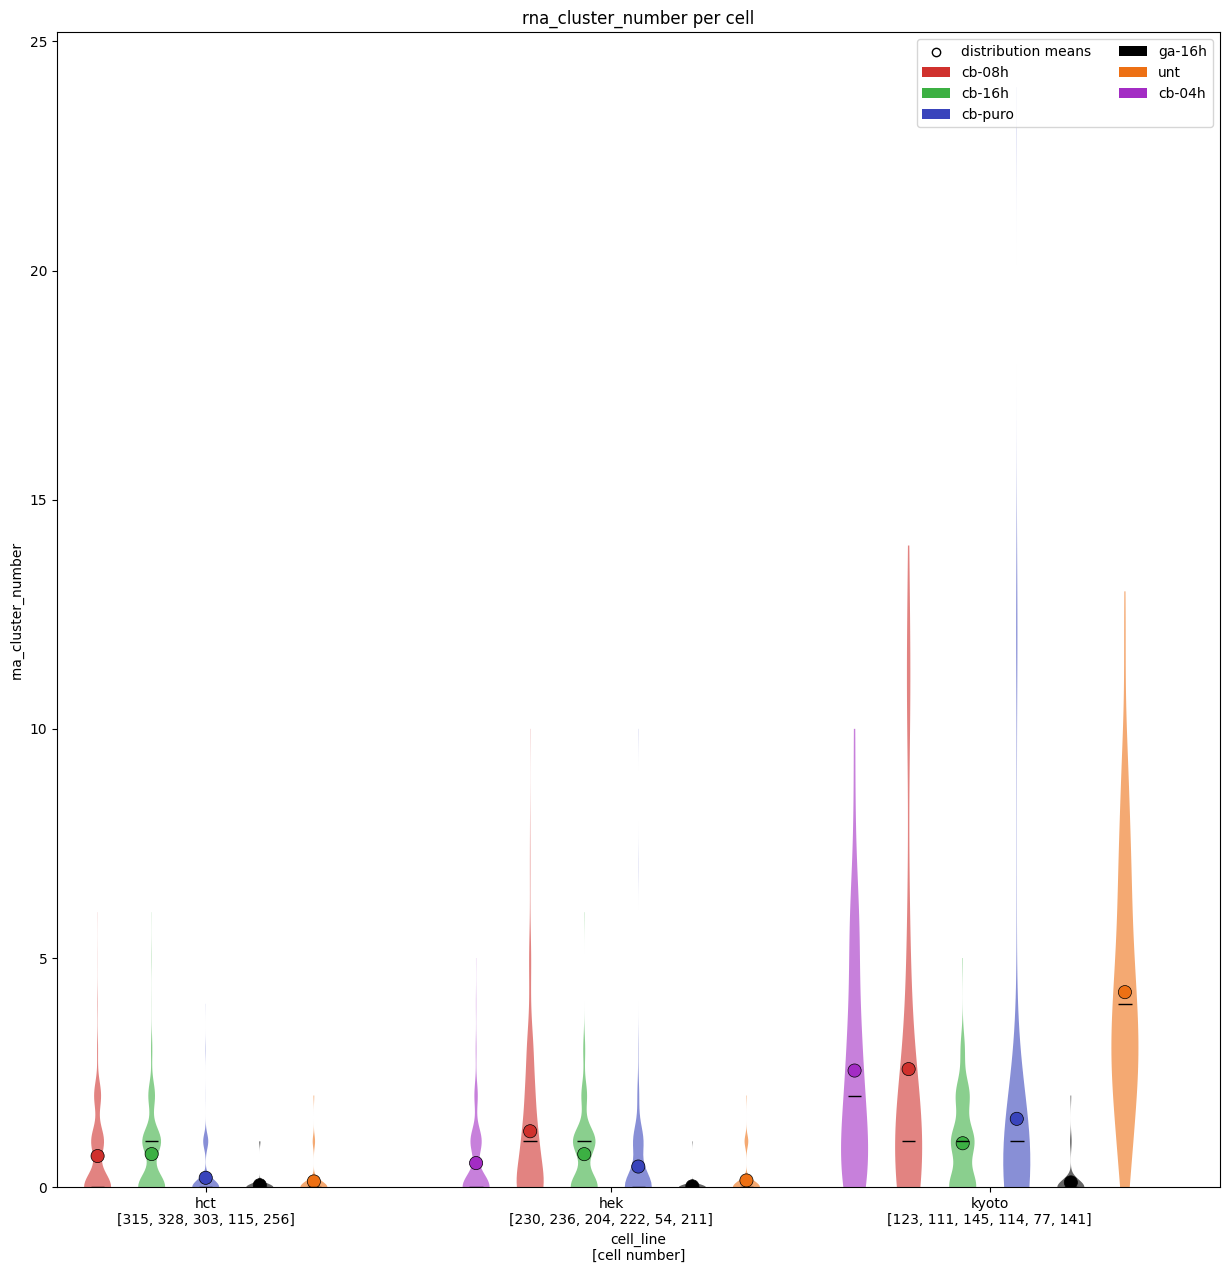

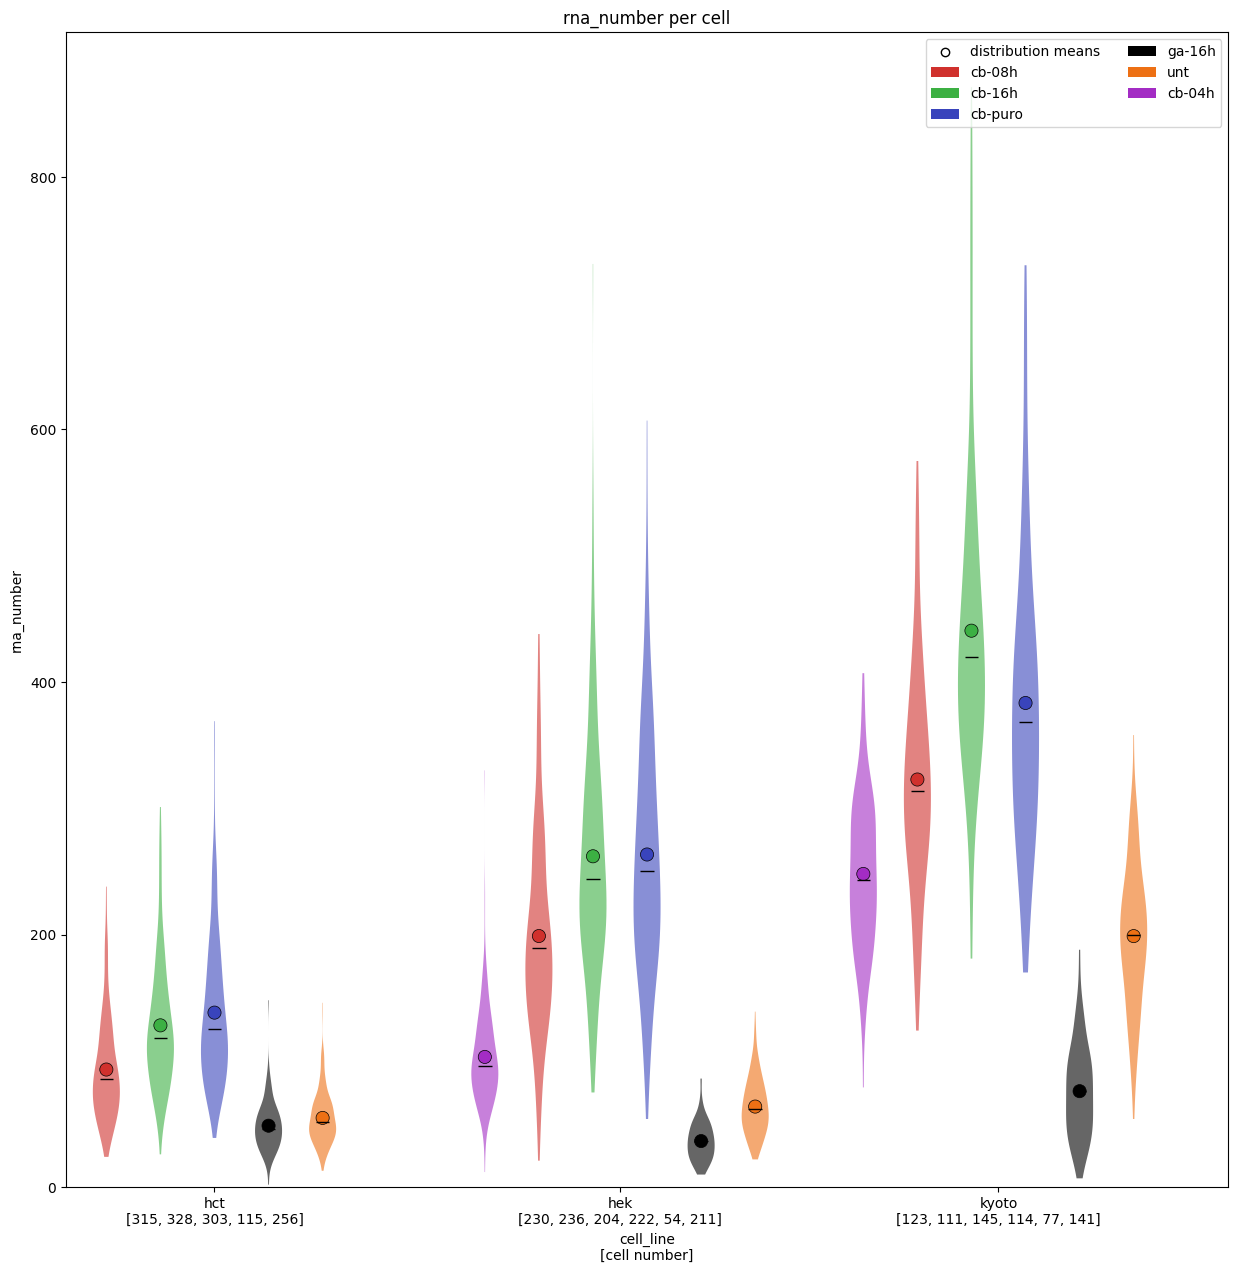

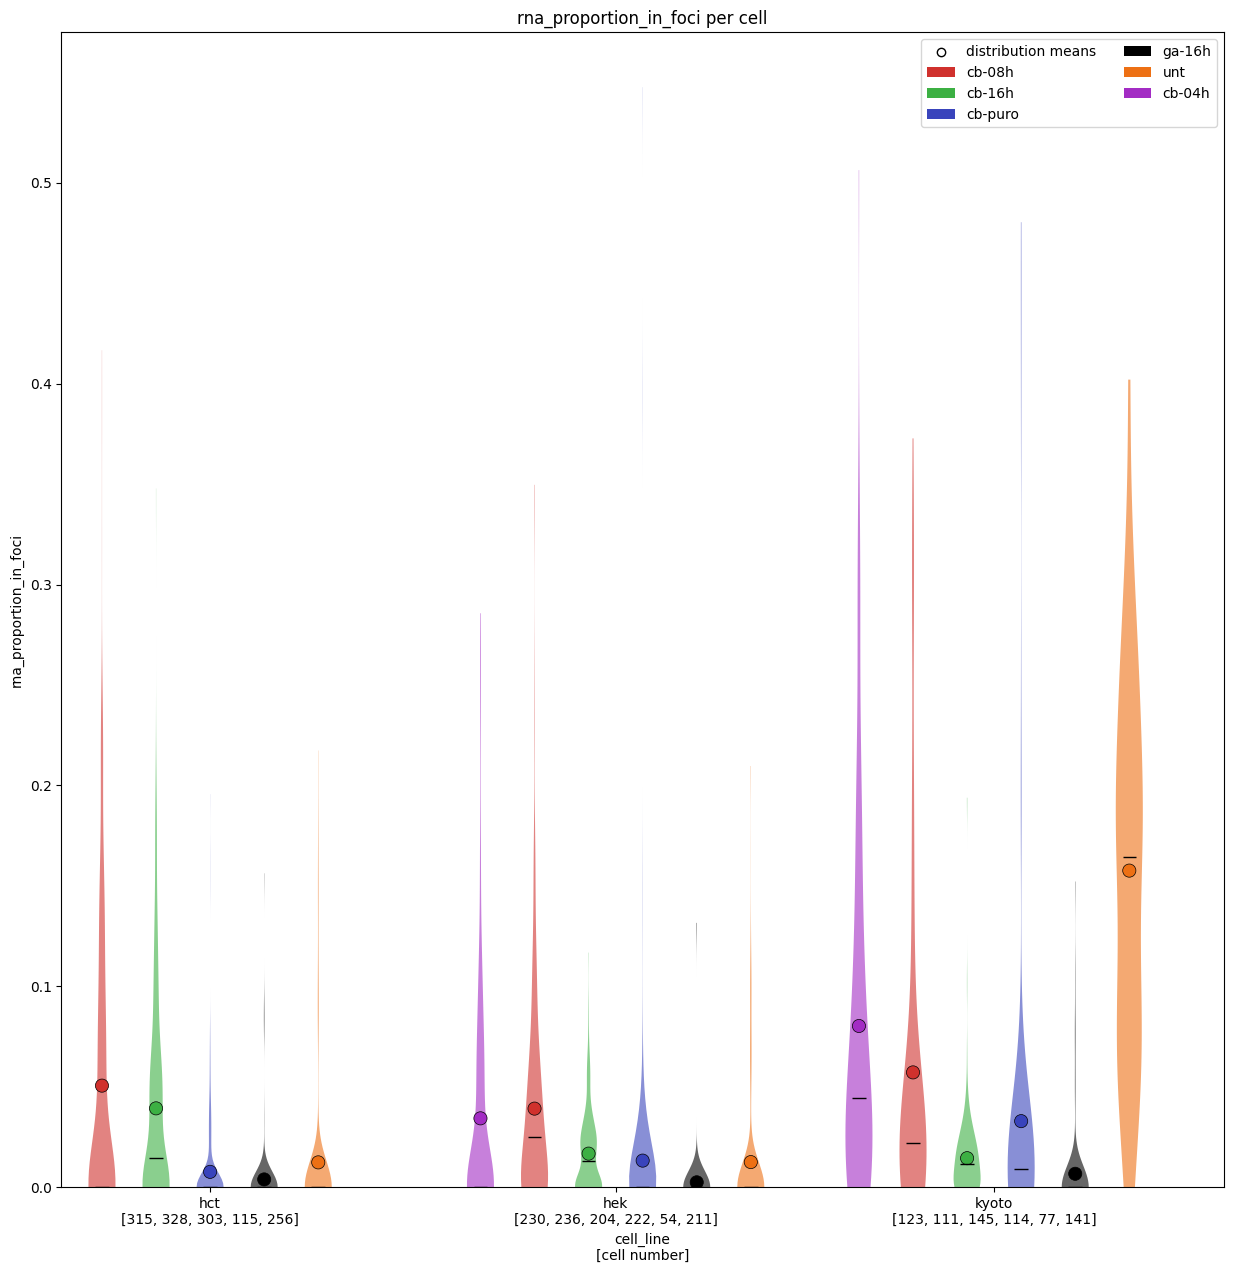

In [47]:
if sub_data.index.nlevels == 2 :
    for key in measure_keys :
        fig = plt.figure(figsize= FIGSIZE)
        ax = fig.gca()
        ax = plot.distribution_super_plot(
                data=sub_data[key],
                ax=ax,
                title= key + " per cell",
                xlabel= '{0}\n[cell number]'.format(sub_data.index.names[0]),
                ylabel= key
            )
        ax.set_ylim(bottom=0)
        fig.savefig(PATH_OUT + '/distribution/{0}/{0}_all_samples_distribution.png'.format(key))
plt.show()


In [48]:
for index in level0 : 
    for key in measure_keys :
        key_data = sub_data.loc[index,[key]].squeeze()

        fig = plt.figure(figsize= (FIGSIZE[0]*2, FIGSIZE[1]))
        left_ax,right_ax = fig.subplots(1,2)
        left_ax = plot.distribution_super_plot(
            data=key_data,
            ax=left_ax,
            title= key + " per cell ({0})".format(index),
            xlabel= '{0}\n[cell number]'.format(key_data.index.name),
            ylabel= key
        )
        left_ax.set_ylim(bottom=0)

        right_ax = pairwise_test_tile(
            ax=right_ax,
            pvalues=pvalues_df.loc[index].dropna(axis=1),
            measure= key,
            significance=SIGNIFICANCE
        )

        right_ax.set_xlim(0,len(pvalues_df.loc[index].dropna(axis=1).columns.get_level_values(-1).unique()))
        right_ax.set_ylim(0,len(pvalues_df.loc[index].dropna(axis=1).columns.get_level_values(-1).unique()))

        fig.tight_layout()
        fig.savefig(PATH_OUT + '/distribution/{0}/{1}_{0}_distribution.png'.format(key,index))
        plt.close()
plt.show(block=False)